In [1]:
%load_ext watermark
%watermark

2020-09-09T13:03:48-05:00

CPython 3.7.6
IPython 7.13.0

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-47-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)

In [3]:
vehiculos = pd.read_csv("vehiculos_procesado.csv", usecols=["consumo", "co2", "cilindros", "desplazamiento"])
litros_por_galon = 3.78541
vehiculos["consumo_litros_milla"] = litros_por_galon/vehiculos.consumo

In [4]:
vehiculos.shape

(35539, 5)

In [5]:
vehiculos.head()

,desplazamiento,cilindros,consumo,co2,consumo_litros_milla
0,2.5,4.0,17,522.764706,0.222671
1,4.2,6.0,13,683.615385,0.291185
2,2.5,4.0,16,555.437500,0.236588
3,4.2,6.0,13,683.615385,0.291185
4,3.8,6.0,16,555.437500,0.236588


El modelo tiene la forma:

Lo que se busca en la regresión es generar un modelo de determinadas caracteristicas.

$$\hat{y} = \alpha + \beta_1 * x_1 + \beta_2 * x_2 + ... + \beta_n * x_n + \epsilon$$

$\hat{y} \rightarrow$ Predicción de la variable objetivo

$\alpha \rightarrow$ Termino independiente

$\beta_i \rightarrow$ Coeficiente de la variable de entrada $i$

$x_i \rightarrow$ valor de la variable de entrada $i$

$\epsilon \rightarrow$ Residuo (error)

El objetivo es obtener $\alpha$ y $\beta_n$ tales que error cuadratico (residuo) sea el minimo

$$RSS = \epsilon^2 = \displaystyle\sum_{i=1}^{n} (y_i - [\alpha - (\beta_ix_i)]^2$$

Para ello debemos resolver: 

$$\hat{\alpha} = \bar{y}-\hat{\beta}*\bar{x}$$
$$\hat{\beta} = (X^TX)^{-1}X^Ty$$

Para obtener los coeficimient utilizamos una fracción del dataset a entrenar y otra a evaluar (para evitar sobreajuste o sobregeneralización)

In [6]:
pct_entrenamiento = 0.8

In [7]:
vehiculos_training = vehiculos.sample(frac=pct_entrenamiento)

vehiculos_test = vehiculos[~vehiculos.index.isin(vehiculos_training.index)]
print(vehiculos_training.shape)
print(vehiculos_test.shape)

(28431, 5)
(7108, 5)


In [8]:
variables_independientes = ["desplazamiento", "cilindros", "consumo_litros_milla"]
variable_dependiente = "co2"
X = vehiculos_training[variables_independientes].values
y = vehiculos_training[variable_dependiente].values
X_T = X.T #transpuesta de X

In [9]:
X

array([[5.        , 8.        , 0.27038643],
       [3.2       , 6.        , 0.23658813],
       [3.        , 6.        , 0.18025762],
       ...,
       [1.6       , 4.        , 0.18025762],
       [1.8       , 4.        , 0.14020037],
       [2.        , 4.        , 0.17206409]])

In [10]:
X.shape

(28431, 3)

In [11]:
y

array([634.78571429, 555.4375    , 423.19047619, ..., 423.19047619,
       329.14814815, 403.95454545])

In [12]:
betas = np.linalg.inv(X_T @ X) @ X_T @ y
betas

array([ 3.81542270e+00, -6.12383036e-01,  2.30546466e+03])

In [13]:
y.mean()

470.56140844401045

In [14]:
alfa = y.mean() - np.dot(betas,vehiculos_training[variables_independientes].mean().values)
alfa

0.36263124628993637

In [15]:
def predecir(record):
    return alfa + np.dot(betas, record.values)

In [16]:
vehiculos_training["co2_pred"] = vehiculos_training[variables_independientes].apply(predecir, axis=1)
vehiculos_test["co2_pred"] = vehiculos_test[variables_independientes].apply(predecir, axis=1)

/home/buitrago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
vehiculos_training[["co2","co2_pred"]].head()

,co2,co2_pred
14117,634.785714,637.907035
18652,555.437500,554.343246
1431,423.190476,423.712171
28093,522.764706,524.547467
17580,493.722222,494.882811


In [18]:
vehiculos_test[["co2", "co2_pred"]].head()

,co2,co2_pred
6,370.291667,369.937403
10,444.350000,444.491050
13,444.350000,444.491050
16,467.736842,468.220263
18,467.736842,468.220263


In [19]:
model_formula = "y ~ {alfa:.3f} + {beta_1:.2f}*desplazamiento + {beta_2:.2f}*cilindros + {beta_3:.2f}*consumo_litros_milla".format(
    alfa=alfa, beta_1=betas[0], beta_2=betas[1], beta_3=betas[2])
model_formula

'y ~ 0.363 + 3.82*desplazamiento + -0.61*cilindros + 2305.46*consumo_litros_milla'

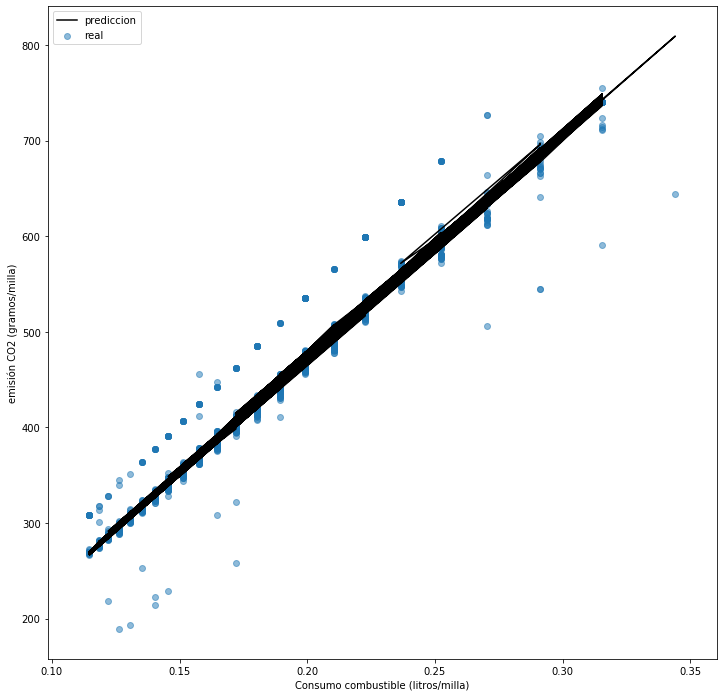

In [20]:
plt.scatter(vehiculos_test.consumo_litros_milla, vehiculos_test.co2, alpha=0.5, label="real")
plt.plot(vehiculos_test.consumo_litros_milla, vehiculos_test.co2_pred, color="black", label="prediccion")
plt.xlabel("Consumo combustible (litros/milla)")
plt.ylabel("emisión CO2 (gramos/milla)")
plt.legend()

In [21]:
def error_cuadratico_medio(y,y_pred):
    return np.sum((y-y_pred)**2)/len(y)

In [22]:
error_training = error_cuadratico_medio(vehiculos_training.co2, vehiculos_training.co2_pred)
error_training

132.18427721705

In [23]:
error_test = error_cuadratico_medio(vehiculos_test.co2, vehiculos_test.co2_pred)
error_test

127.7883469693809